# Exploring the UTx000 Extension EMA Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

## Self-Report vs Measured Sleep
In this notebook we take a more in-depth look at self-report vs Fitbit-measure sleep metrics.

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels.api as sm

## Data Import
Here we import the morning surveys and the daily Fitbit data

### Morning Sleep Surveys

In [3]:
sr_sleep = pd.read_csv('../data/processed/bpeace2-morning-survey.csv',index_col=0,parse_dates=True)
print(f'Length before removing NaNs:\t{len(sr_sleep)}')
for column in ['TST','SOL','NAW','Restful']:
    sr_sleep = sr_sleep[sr_sleep[column].notna()]
print(f'Length after removing NaNs:\t{len(sr_sleep)}')
sr_sleep.head()

Length before removing NaNs:	1682
Length after removing NaNs:	1672


,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful
2020-07-31 14:25:00,hfttkth7,1,2,1.0,3,0,6.0,10.0,3.0,0
2020-08-20 03:49:00,hfttkth7,1,1,0.0,1,2,7.0,20.0,1.0,1
2020-08-23 15:58:00,hfttkth7,1,1,1.0,2,0,6.0,25.0,0.0,0
2020-07-17 14:52:00,hfttkth7,1,1,0.0,1,2,7.0,20.0,3.0,2
2020-08-12 17:32:00,hfttkth7,1,3,1.0,2,2,6.0,20.0,0.0,1


### Daily Fitbit Metrics

In [4]:
fb_sleep = pd.read_csv("../data/processed/bpeace2-fitbit-sleep-daily.csv",index_col=0,parse_dates=True)
fb_sleep.head()

,dateOfSleep,duration,efficiency,endTime,infoCode,isMainSleep,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,minutesToFallAsleep,startTime,timeInBed,beiwe
date,,,,,,,,,,,,,,
2020-05-01,2020-05-01,38400000,92,2020-05-01T12:12:30.000,0,True,26980914882,0,567,73,0,2020-05-01T01:32:30.000,640,15tejjtw
2020-05-02,2020-05-02,39060000,91,2020-05-02T13:13:00.000,0,True,26996086598,0,557,94,0,2020-05-02T02:21:30.000,651,15tejjtw
2020-05-03,2020-05-03,21660000,88,2020-05-03T08:01:00.000,0,True,27009771663,1,301,60,0,2020-05-03T01:59:30.000,361,15tejjtw
2020-05-04,2020-05-04,36480000,89,2020-05-04T14:13:30.000,0,True,27022238683,0,515,93,0,2020-05-04T04:05:00.000,608,15tejjtw
2020-05-06,2020-05-06,30420000,87,2020-05-06T10:24:00.000,0,True,27052041978,0,433,74,0,2020-05-06T01:56:30.000,507,15tejjtw


## Data Summary and Comparison
Since both the survey and fitbit-recorded sleep are on the same resolution, we can easily compare their overall statistics.

### Aggregate Comparison
Here we look at the aggregated data across all participants for the two data modalities.

In [5]:
# n
print(f'Number of sleep surveys:\t{len(sr_sleep)}')
print(f'Number of fitbit records:\t{len(fb_sleep)}')

Number of sleep surveys:	1672
Number of fitbit records:	2701


<div class="alert alert-block alert-warning">

There seem to be quite a few records to look at, however we have to see how many nightly records actually overlap. 

- The sleep surveys are indexed by the day that the participant woke up.
- Fitabase data dictionary does not have a record for ```dateOfSleep``` although they do have ```sleepDate```, however these seem to be different variables. Looking at the data, ```dateOfSleep``` seems to correspond to the date of the ```endTime``` label not the ```startTime``` label which Fitabase suggests.

Based on the points above, we just have to check the overlap between the **date of the sleep survey data** and the **date of the fitbit sleep data** per participant to see the combined records that are available.
    
</div>

In [6]:
# creating date column
sr_sleep['date'] = pd.to_datetime(sr_sleep.index.date)
print(type(sr_sleep['date'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


First, let's check that we have the same participants for both modalities:

In [7]:
# Pts with fitbits
fb_beiwe = fb_sleep['beiwe'].unique()
# Pts who took surveys
sr_beiwe = sr_sleep['ID'].unique()
print(f'Number of Fitbit Participants:\t{len(fb_beiwe)}\nNumber of Survey Participants:\t{len(sr_beiwe)}')


Number of Fitbit Participants:	37
Number of Survey Participants:	50


In [8]:
# list of pts from both
pt_list = np.intersect1d(fb_beiwe,sr_beiwe)
print(f'Length of Intersecting Participants:\t{len(pt_list)}')
print(pt_list)

Length of Intersecting Participants:	34
['15tejjtw' '1a9udoc5' '2xtqkfz1' '4i7679py' '5fvmg226' '745vq78e'
 '7dhu3pn7' '9jtzsuu8' '9xmhtq74' 'axk49ssu' 'e73a1pd5' 'e8js2jdf'
 'eyf8oqwl' 'h8aoiyhv' 'hcpu5myv' 'hfttkth7' 'hxj6brwj' 'i4w8dx6l'
 'idbkjh8u' 'itmylz3g' 'lkkjddam' 'mm69prai' 'oxcpr7e3' 'rnse61g4'
 'rvhdl2la' 't4jphih6' 'tlmlq19s' 'tmexej5v' 'vpy1a985' 'vr9j5rry'
 'xdbdrk6e' 'xlw5ntd5' 'y1tvkx14' 'zdpffrox']


Now we can loop through the participants, combining days of self-report and measured sleep metrics when both records exist. 

In [9]:
combined_sleep = pd.DataFrame() # dataframe to append to
for pt in pt_list:
    sr_sleep_beiwe = sr_sleep[sr_sleep['ID'] == pt]
    fb_sleep_beiwe = fb_sleep[fb_sleep['beiwe'] == pt]
    combined_sleep = combined_sleep.append(pd.merge(left=sr_sleep_beiwe,right=fb_sleep_beiwe,left_on='date',right_index=True,how='inner'))


Now we can see how many nights of data we have from both modalities in addition to if we lost any participants due to lack of overlap.

In [10]:
print(f'Number of overlapping nights: {len(combined_sleep)}')
n = len(combined_sleep['ID'].unique())
print(f'\tFrom {n} participants')

Number of overlapping nights: 741
	From 34 participants


So we have just over 600 nights of data, but we lost one participant from lack of overlap. Now we can start to look at the different metrics recorded by both modalities.

#### Total Sleep Time
Total sleep time (TST) in hours

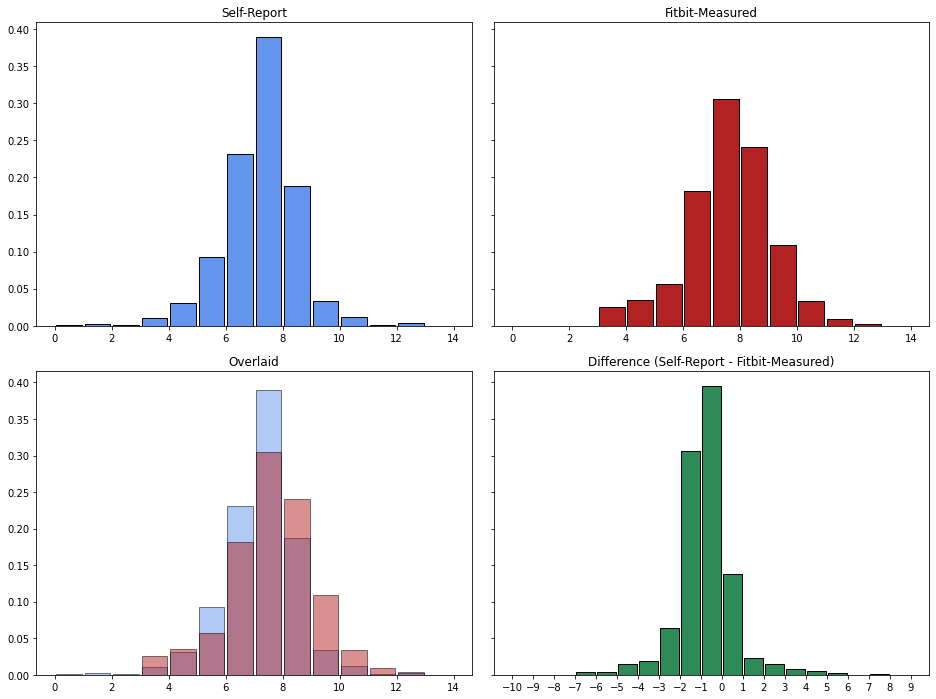

In [11]:
fig, axes = plt.subplots(2,2,figsize=(16,12),sharey='row')
# tst from sr
axes[0,0].hist(combined_sleep['TST'],bins=np.arange(0,15,1),density=True,rwidth=0.9,color='cornflowerblue',edgecolor='black')
axes[0,0].set_title("Self-Report")
# tst from fb
axes[0,1].hist(combined_sleep['duration']/3600000,bins=np.arange(0,15,1),density=True,rwidth=0.9,color='firebrick',edgecolor='black')
axes[0,1].set_title("Fitbit-Measured")
# overlaid
axes[1,0].hist(combined_sleep['TST'],bins=np.arange(0,15,1),density=True,rwidth=0.9,color='cornflowerblue',edgecolor='black',alpha=0.5)
axes[1,0].hist(combined_sleep['duration']/3600000,bins=np.arange(0,15,1),density=True,rwidth=0.9,color='firebrick',edgecolor='black',alpha=0.5)
axes[1,0].set_title("Overlaid")
# difference
n,bins,_ = axes[1,1].hist(combined_sleep['TST']-combined_sleep['duration']/3600000,bins=np.arange(-10,10,1),density=True,rwidth=0.9,color='seagreen',edgecolor='black')
axes[1,1].set_xticks(bins)
axes[1,1].set_title("Difference (Self-Report - Fitbit-Measured)")

plt.subplots_adjust(wspace=0.05,hspace=0.15)
plt.show()
plt.close()

<div class="alert alert-block alert-warning">
    
Results are interesting particularly when analyzing the difference histrogram in the (2,2) location. 

The first result can be interpreted one of two ways:
1. On average, Fitbit **over-estimates** the TST
2. On average, participants **under-estimate** their TST

The second result can again be interpreted one of two ways depending on what we think is the more accurate measure:
1. Fitbit, in some instances, tends to dramatically under-predict TST
2. There are some participants who dramatically over-predict their sleep, or these are simply odd isntances when participants calculated their sleep time incorrectly.

For the second observation, I think the latter point is more valid - that some participants poorly gauged their TST and did not account for the time it took them to fall asleep or instances when the woke in the evening. However, I don't think that explains how the differences could be three or more hours different. **Days with a difference of more than 3(?) hours (absolute value) should be removed from the dataset because, in either case, something is amiss.**

<div class="alert alert-block alert-danger">
What is the best way to deal with TST differences that are so largely negative and/or positive?

We try two methods to remove values of TST that don't agree. We have to start by creating a new variable that is the absolute value of the difference between the two measurements. Then we can do outlier detection on that distribution. 
1. Z-Score: We calculate the z-score of the differences and only use TST values where the z-score is less than 2.5 for the difference
2. IQR: We calculate the IQR for the difference in TST between modalities and remove values that are $1.5*IQR$ greater than the 75% percentile and $1.5*IQR$ less than the 25% percentile.

In [12]:
combined_sleep['TST_Difference'] = combined_sleep['TST'] - combined_sleep['duration']/3600000
combined_sleep['Difference_Z'] = (combined_sleep['TST_Difference'] - np.mean(combined_sleep['TST_Difference'])) / np.std(combined_sleep['TST_Difference'])
reduced_sleep_z = combined_sleep[abs(combined_sleep['Difference_Z']) < 2.5]

iqr = np.percentile(combined_sleep['TST_Difference'],75) - np.percentile(combined_sleep['TST_Difference'],25)
reduced_sleep_iqr = combined_sleep[(combined_sleep['TST_Difference'] < np.percentile(combined_sleep['TST_Difference'],75) + 1.5*iqr) & (combined_sleep['TST_Difference'] > np.percentile(combined_sleep['TST_Difference'],25) - 1.5*iqr)]

print(f'N for Complete Dataset:\t\t\t{len(combined_sleep)}')
print(f'N for Reduced Dataset (z-score):\t{len(reduced_sleep_z)}')
print(f'N for Reduced Dataset (iqr):\t\t{len(reduced_sleep_iqr)}')

N for Complete Dataset:			741
N for Reduced Dataset (z-score):	712
N for Reduced Dataset (iqr):		681


In [13]:
slope_models = []
full_models = []
dataset_labels = ['Complete','Reduced by Z-Score','Reduced by 1.5xIQR']
for df, dataset in zip([combined_sleep,reduced_sleep_z,reduced_sleep_iqr],dataset_labels):
    print(f'OLS for {dataset} Dataset')
    x = df['duration'].values/3600000
    y = df['TST'].values
    # OLS - intercept at origin
    slope_model = sm.OLS(y,x).fit()
    print("\tSlope Model")
    print(f"\t\tParams:\t{slope_model.params}\n\t\tR^2:\t{slope_model.rsquared}")
    slope_models.append(slope_model)
    # OLS - intercept included
    full_model = sm.OLS(y,sm.add_constant(x)).fit()
    print("\tFull Model")
    print(f"\t\tParams:\t{full_model.params}\n\t\tR^2:\t{full_model.rsquared}")
    full_models.append(full_model)

OLS for Complete Dataset
	Slope Model
		Params:	[0.88014485]
		R^2:	0.9665955647684106
	Full Model
		Params:	[3.15308914 0.48194297]
		R^2:	0.29588023283511367
OLS for Reduced by Z-Score Dataset
	Slope Model
		Params:	[0.88245852]
		R^2:	0.9826382159311576
	Full Model
		Params:	[2.09548112 0.61859734]
		R^2:	0.5223718607367337
OLS for Reduced by 1.5xIQR Dataset
	Slope Model
		Params:	[0.88929593]
		R^2:	0.9886250817054905
	Full Model
		Params:	[1.50550193 0.6992658 ]
		R^2:	0.6486846519443734


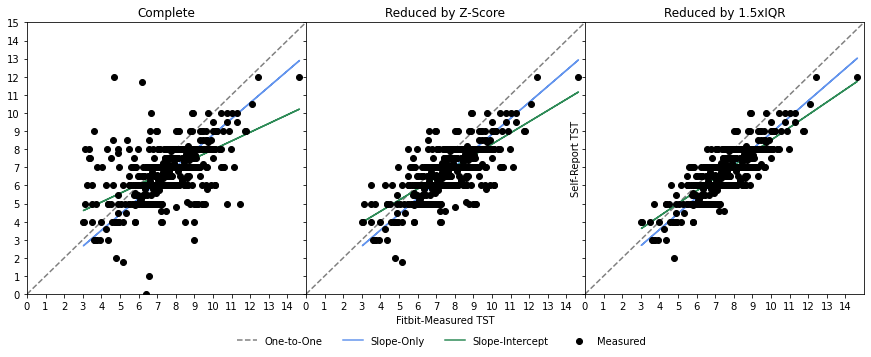

In [14]:
fig, axes = plt.subplots(1,3,figsize=(15,5),sharey='row')
dfs = [combined_sleep,reduced_sleep_z,reduced_sleep_iqr]
for i in range(3):
    ax = axes[i]
    df = dfs[i]
    # data
    ax.scatter(df['duration']/3600000,df['TST'],color='black',zorder=10,label='Measured')
    # one-to-one
    ax.plot([0,15],[0,15],color='gray',linestyle='dashed',zorder=1,label='One-to-One')
    # slope
    ax.plot(df['duration'].values/3600000,slope_models[i].fittedvalues,color='cornflowerblue',label='Slope-Only')
    # full
    ax.plot(df['duration'].values/3600000,full_models[i].fittedvalues,color='seagreen',label='Slope-Intercept')

    ax.set_xlim([0,15])
    ax.set_ylim([0,15])
    ax.set_xticks(np.arange(0,15,1))
    ax.set_yticks(np.arange(0,16,1))
    ax.set_title(dataset_labels[i])
    if i == 1:
        ax.set_xlabel('Fitbit-Measured TST')
    if i == 2:
        ax.legend(bbox_to_anchor=(0.25,-0.12),ncol=4,frameon=False)

ax.set_ylabel('Self-Report TST')
plt.subplots_adjust(wspace=0,hspace=0.15)
plt.show()
plt.close()

### Participant Comparison Across Platforms
Now we look at individual participants and how they compared across the different modalities. With these figures it is important to highlight the individuals if possible. Some ideas include:
- Scatter with color for participants
- m-by-n figure that includes all participants with dots colored and line of best fit included where the other dots are monocolor (I like this one)

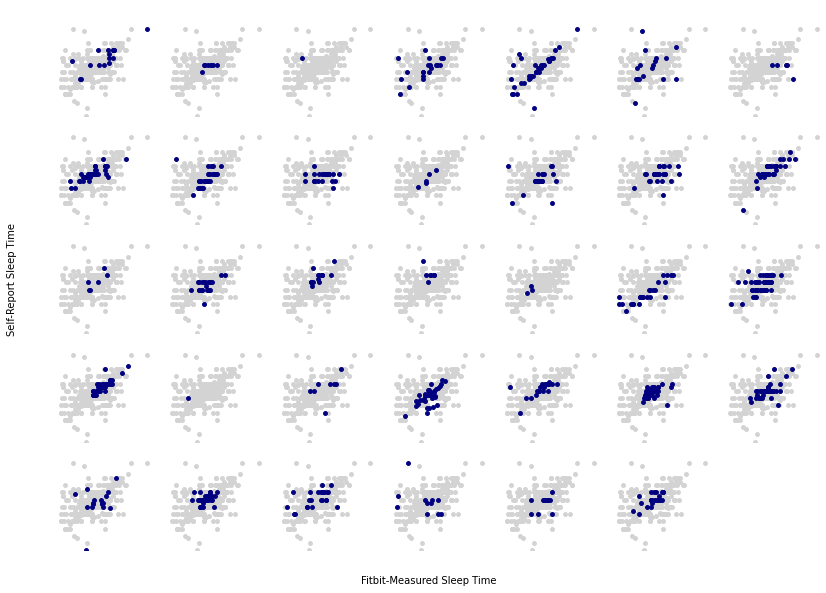

In [17]:
fig, ax = plt.subplots(5,7,figsize=(14,10),sharex='col',sharey='row')
i = 0
rows = [0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,4,4,4,4]
cols = [0,1,2,3,4,5,6]*5
for pt, r, c in zip(combined_sleep['ID'].unique(),rows,cols):
    pt_df = combined_sleep[combined_sleep['ID'] == pt]
    nonpt_df = combined_sleep[combined_sleep['ID'] != pt]
    ax[r,c].scatter(nonpt_df['duration']/3600000,nonpt_df['TST'],s=15,color='lightgray',zorder=1)
    ax[r,c].scatter(pt_df['duration']/3600000,pt_df['TST'],s=15,color='navy',zorder=2)
    ax[r,c].set_xlim([0,15])
    ax[r,c].set_ylim([0,15])
    if r == 0:
        ax[r,c].set_yticks([0,5,10,15])
    else:
        ax[r,c].set_yticks([0,5,10])
        
    if c == 6:
        ax[r,c].set_xticks([0,5,10,15])
    else:
        ax[r,c].set_xticks([0,5,10])
        
    #ax[r,c].text(1,13.75,f'{pt}',ha='left',va='center')
        
    i+=1
ax[2,0].text(-3.5,7.5,'Self-Report Sleep Time',rotation=90,ha='center',va='center')
ax[4,3].text(7.5,-3.5,'Fitbit-Measured Sleep Time',ha='center',va='top')
plt.subplots_adjust(wspace=0,hspace=0)
plt.axis('off')
#plt.savefig('../reports/BuildSys2020/fitbit-beiwe-tst-tst-comprehensive-scatter.pdf')
plt.show()
plt.close()

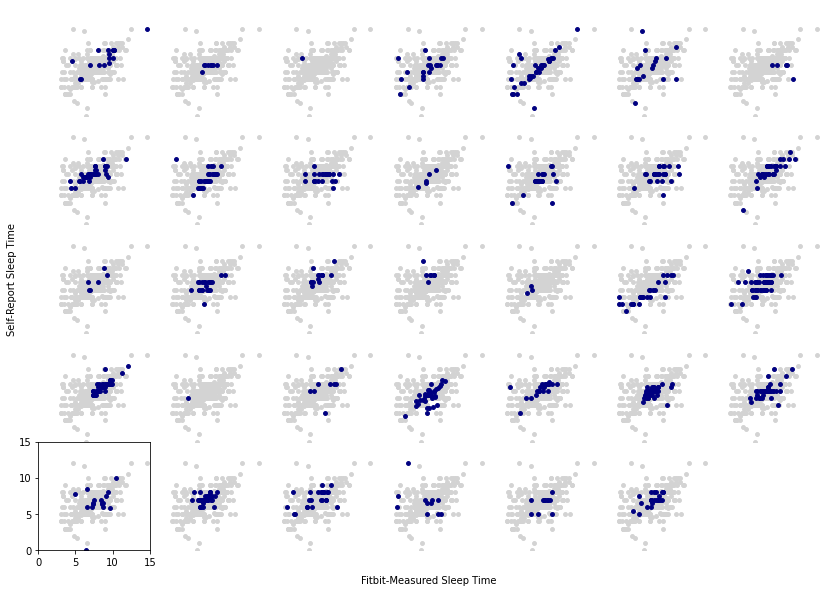

In [22]:
fig, ax = plt.subplots(5,7,figsize=(14,10),sharex='col',sharey='row')
i = 0
rows = [0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,4,4,4,4]
cols = [0,1,2,3,4,5,6]*5
for pt, r, c in zip(combined_sleep['ID'].unique(),rows,cols):
    pt_df = combined_sleep[combined_sleep['ID'] == pt]
    nonpt_df = combined_sleep[combined_sleep['ID'] != pt]
    ax[r,c].scatter(nonpt_df['duration']/3600000,nonpt_df['TST'],s=15,color='lightgray',zorder=1)
    ax[r,c].scatter(pt_df['duration']/3600000,pt_df['TST'],s=15,color='navy',zorder=2)
    ax[r,c].set_xlim([0,15])
    ax[r,c].set_ylim([0,15])
    if r == 4:
        ax[r,c].set_xticks([0,5,10,15])
    else:
        ax[r,c].axis('off')
        
    if c == 0:
        ax[r,c].set_yticks([0,5,10,15])
    else:
        ax[r,c].axis('off')
        
    #ax[r,c].text(1,13.75,f'{pt}',ha='left',va='center')
        
    i+=1
ax[2,0].text(-3.5,7.5,'Self-Report Sleep Time',rotation=90,ha='center',va='center')
ax[4,3].text(7.5,-3.5,'Fitbit-Measured Sleep Time',ha='center',va='top')
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('../reports/BuildSys2020/fitbit-beiwe-tst-tst-comprehensive-scatter.pdf')
plt.axis('off')
plt.show()
plt.close()

# Filtered Dataset Analysis
These next cells take a closer look at the sleep metrics from Fitbit and the EMAs for the filtered datasets rather than any night that we have data from both.

## Aggregate Comparison
We want to see how sleep metrics vary in bulk.

### Bland Altman Difference Plot
See [here](https://www.statsmodels.org/devel/generated/statsmodels.graphics.agreement.mean_diff_plot.html) for some more information.

## Participant Comparison
We want to show how the participant sleep metric measurements vary across devices

### Scatter Plot - Participant versus the Study
Similar to the scatter plots shown above, but with a different dataset. 